# HoneyBee Radiology Processing Tutorial

This comprehensive tutorial demonstrates the radiology processing capabilities of HoneyBee, including:
- Loading DICOM and NIfTI files
- Image preprocessing and enhancement
- Anatomical segmentation
- Spatial standardization
- Embedding generation for downstream AI tasks

---

## Table of Contents
1. [Setup and Installation](#setup)
2. [Loading Medical Images](#loading)
3. [Image Preprocessing](#preprocessing)
4. [Window/Level Adjustment](#windowing)
5. [Denoising Techniques](#denoising)
6. [Anatomical Segmentation](#segmentation)
7. [Spatial Standardization](#spatial)
8. [Intensity Normalization](#normalization)
9. [Embedding Generation](#embeddings)
10. [Complete Pipeline Example](#pipeline)
11. [Advanced Topics](#advanced)

## 1. Setup and Installation <a id='setup'></a>

First, let's import all necessary libraries and set up our environment.

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add HoneyBee to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./'))))

# Import HoneyBee components
from honeybee.processors import RadiologyProcessor, RadiologyImage

# Set up visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("HoneyBee Radiology Processing loaded successfully!")

HoneyBee Radiology Processing loaded successfully!


### Initialize the RadiologyProcessor

The RadiologyProcessor supports different embedding models:
- **REMEDIS**: Medical image embeddings specialized for radiology
- **RadImageNet**: Pre-trained models for radiological image analysis

In [2]:
# Initialize the processor
processor = RadiologyProcessor(model="remedis")
print(f"Processor initialized with {processor.model_name} model on {processor.device}")

2025-06-20 09:58:40,198 - honeybee.processors.radiology_processor - INFO - RadiologyProcessor initialized with remedis model on cuda


Processor initialized with remedis model on cuda


## 2. Loading Medical Images <a id='loading'></a>

HoneyBee supports multiple medical imaging formats:
- **DICOM**: The standard format for medical imaging
- **NIfTI**: Common in research and neuroimaging
- **NRRD/MHD**: Other medical imaging formats

### Loading DICOM Files

In [3]:
# Path to sample CT DICOM series
ct_dir = Path("./samples/CT/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915/")

# Load DICOM series
ct_image = processor.load_dicom(ct_dir)

print(f"Loaded CT image:")
print(f"  Shape: {ct_image.shape}")
print(f"  Data type: {ct_image.dtype}")
print(f"  Intensity range: [{ct_image.data.min():.1f}, {ct_image.data.max():.1f}]")
print(f"\nMetadata available:")
for key in list(ct_image.metadata.keys())[:8]:
    print(f"  - {key}: {ct_image.metadata[key]}")

Loaded CT image:
  Shape: (101, 512, 512)
  Data type: int32
  Intensity range: [-2048.0, 3072.0]

Metadata available:
  - PatientID: TCGA-61-1740
  - StudyDate: 19941028
  - Modality: CT
  - StudyDescription: a p
  - SeriesDescription: ABD/PELVIS
  - SliceThickness: 5.000000
  - PixelSpacing: [0.976562, 0.976562]
  - RescaleSlope: 1


ImageSeriesReader (0x223e99b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:4.85595



### Visualizing the Loaded Image

Let's create a helper function to visualize slices from our 3D volume.

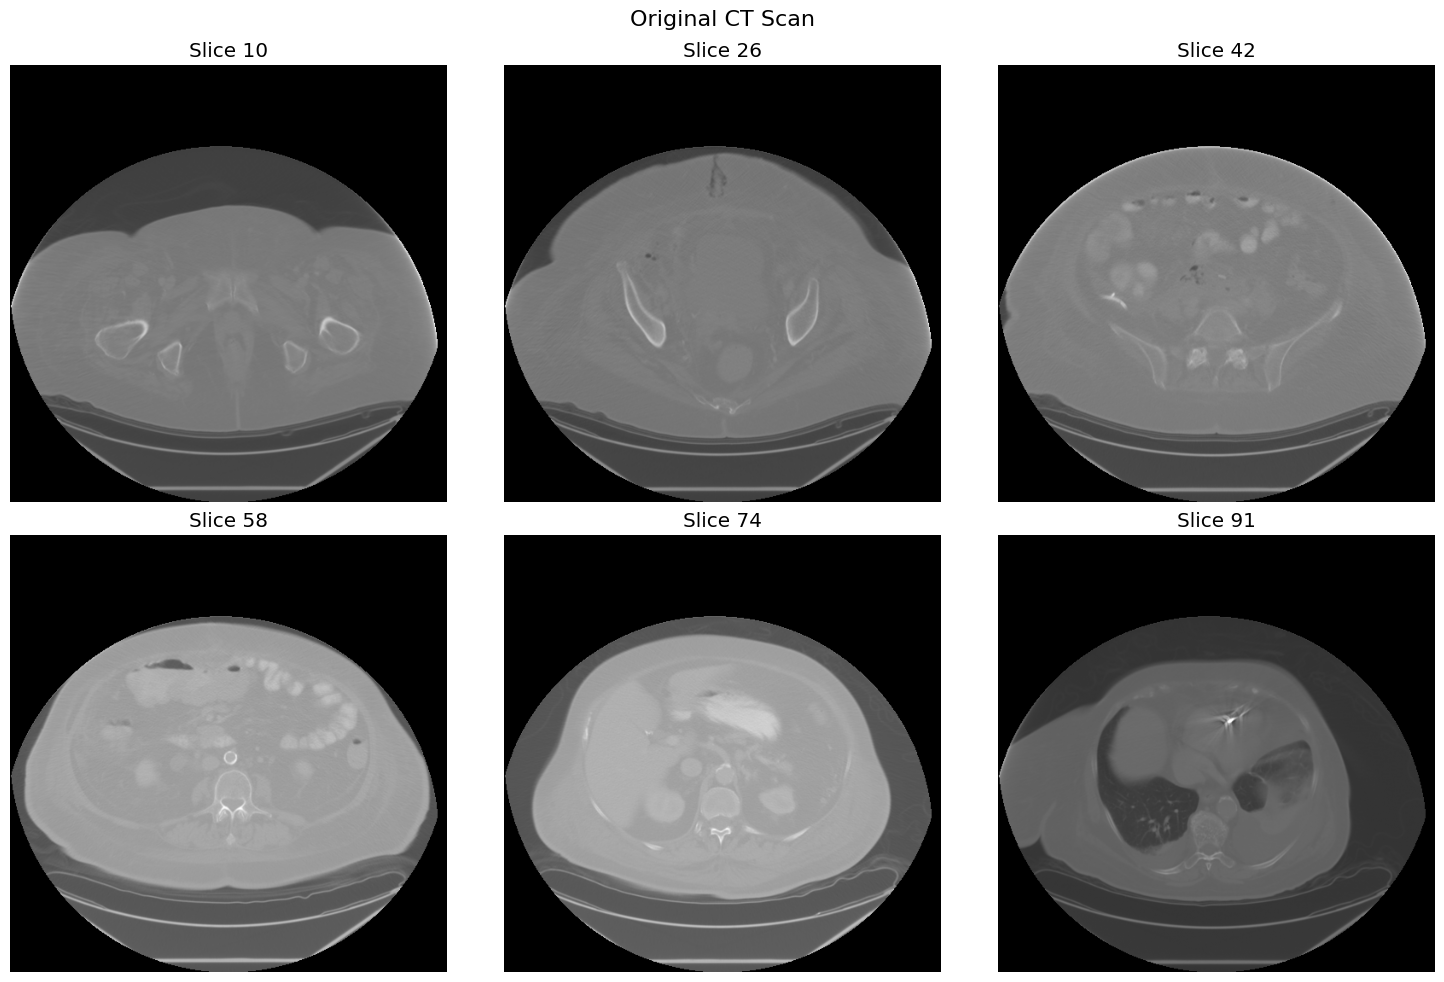

In [4]:
def show_slices(image_data, title="Image", slice_indices=None, cmap='gray'):
    """Display multiple slices from a 3D volume."""
    if slice_indices is None:
        # Show 6 evenly spaced slices
        n_slices = image_data.shape[0]
        slice_indices = np.linspace(10, n_slices-10, 6, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (ax, slice_idx) in enumerate(zip(axes, slice_indices)):
        ax.imshow(image_data[slice_idx], cmap=cmap)
        ax.set_title(f"Slice {slice_idx}")
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show original CT slices
show_slices(ct_image.data, "Original CT Scan")

### Interactive Slice Viewer

For better exploration, let's create an interactive viewer.

In [5]:
from ipywidgets import interact, IntSlider

def view_slice(slice_idx):
    plt.figure(figsize=(10, 10))
    plt.imshow(ct_image.data[slice_idx], cmap='gray')
    plt.colorbar(label='Intensity')
    plt.title(f"CT Slice {slice_idx}/{ct_image.shape[0]-1}")
    plt.axis('off')
    plt.show()

# Create interactive slider
interact(view_slice, slice_idx=IntSlider(min=0, max=ct_image.shape[0]-1, value=20, description='Slice:'))

interactive(children=(IntSlider(value=20, description='Slice:'), Output()), _dom_classes=('widget-interact',))

<function __main__.view_slice(slice_idx)>

## 3. Image Preprocessing <a id='preprocessing'></a>

Preprocessing is crucial for medical image analysis. Let's start with Hounsfield Unit (HU) verification for CT scans.

### Hounsfield Unit Verification

CT scanners measure radiodensity in Hounsfield Units (HU):
- Air: -1000 HU
- Water: 0 HU
- Soft tissue: +40 to +80 HU
- Bone: +700 to +3000 HU

2025-06-20 09:58:43,962 - honeybee.processors.radiology_processor - WARNING - Unusual HU range: [-3072.0, 2048.0]


After HU verification:
  HU range: [-3072.0, 2048.0]


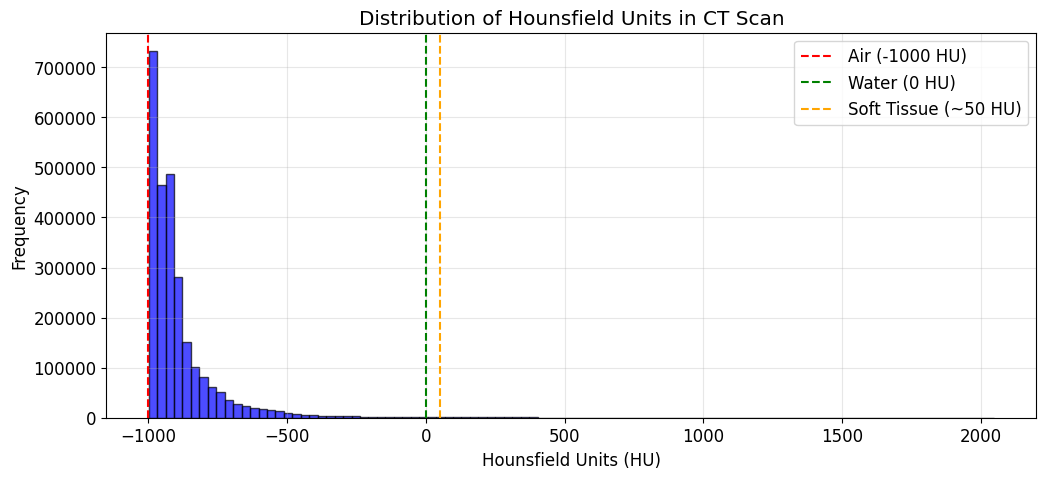

In [6]:
# Verify and correct Hounsfield units
ct_hu = processor.verify_hounsfield_units(ct_image)

print(f"After HU verification:")
print(f"  HU range: [{ct_hu.data.min():.1f}, {ct_hu.data.max():.1f}]")

# Plot histogram of HU values
plt.figure(figsize=(12, 5))
hist_data = ct_hu.data.flatten()
hist_data = hist_data[hist_data > -1000]  # Remove air background

plt.hist(hist_data, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=-1000, color='red', linestyle='--', label='Air (-1000 HU)')
plt.axvline(x=0, color='green', linestyle='--', label='Water (0 HU)')
plt.axvline(x=50, color='orange', linestyle='--', label='Soft Tissue (~50 HU)')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('Distribution of Hounsfield Units in CT Scan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Window/Level Adjustment <a id='windowing'></a>

Different anatomical structures are best visualized with specific window/level settings.

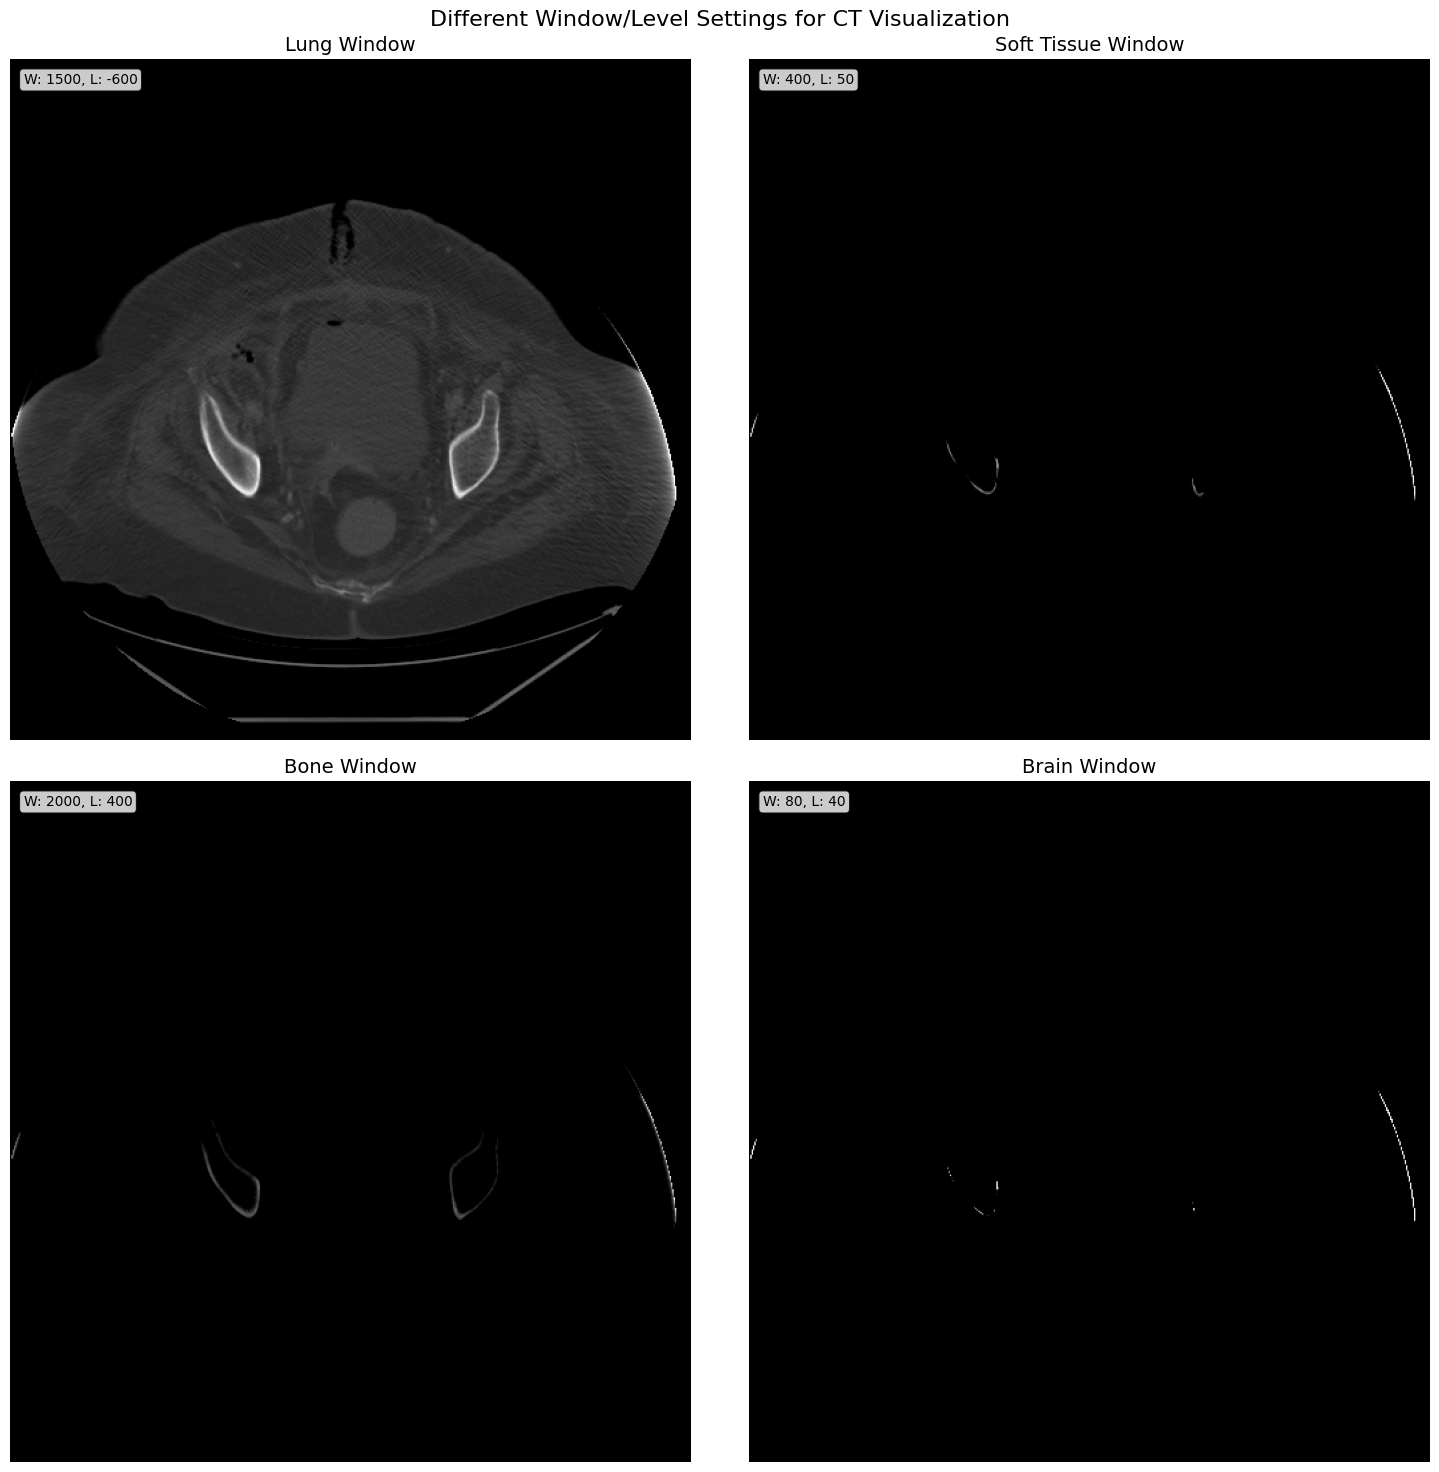

In [7]:
# Apply different window presets
windows = {
    "Lung": processor.apply_window(ct_hu, **processor.WINDOW_PRESETS["lung"]),
    "Soft Tissue": processor.apply_window(ct_hu, **processor.WINDOW_PRESETS["soft_tissue"]),
    "Bone": processor.apply_window(ct_hu, **processor.WINDOW_PRESETS["bone"]),
    "Brain": processor.apply_window(ct_hu, **processor.WINDOW_PRESETS["brain"])
}

# Visualize different windows
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

slice_idx = 25  # Use earlier slice for better lung visualization

for ax, (name, windowed) in zip(axes, windows.items()):
    ax.imshow(windowed.data[slice_idx], cmap='gray')
    ax.set_title(f"{name} Window", fontsize=14)
    ax.axis('off')
    
    # Add window parameters as text
    window_info = f"W: {windowed.metadata['window']}, L: {windowed.metadata['level']}"
    ax.text(0.02, 0.98, window_info, transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top', fontsize=10)

plt.suptitle('Different Window/Level Settings for CT Visualization', fontsize=16)
plt.tight_layout()
plt.show()

### Custom Window/Level Settings

You can also create custom window/level settings for specific visualization needs.

In [ ]:
# Interactive window/level adjustment
from ipywidgets import interact, FloatSlider

def adjust_window(window, level, slice_idx):
    windowed = processor.apply_window(ct_hu, window=window, level=level)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(windowed.data[slice_idx], cmap='gray')
    plt.colorbar(label='Normalized Intensity')
    plt.title(f"Window: {window:.0f}, Level: {level:.0f}")
    plt.axis('off')
    plt.show()

interact(adjust_window, 
         window=FloatSlider(min=1, max=3000, value=400, description='Window:'),
         level=FloatSlider(min=-1000, max=1000, value=50, description='Level:'),
         slice_idx=IntSlider(min=0, max=ct_image.shape[0]-1, value=25, description='Slice:'))

interactive(children=(FloatSlider(value=400.0, description='Window:', max=3000.0, min=1.0), FloatSlider(value=…

<function __main__.adjust_window(window, level, slice_idx)>

## 5. Denoising Techniques <a id='denoising'></a>

Medical images often contain noise that can affect analysis. HoneyBee provides multiple denoising methods.

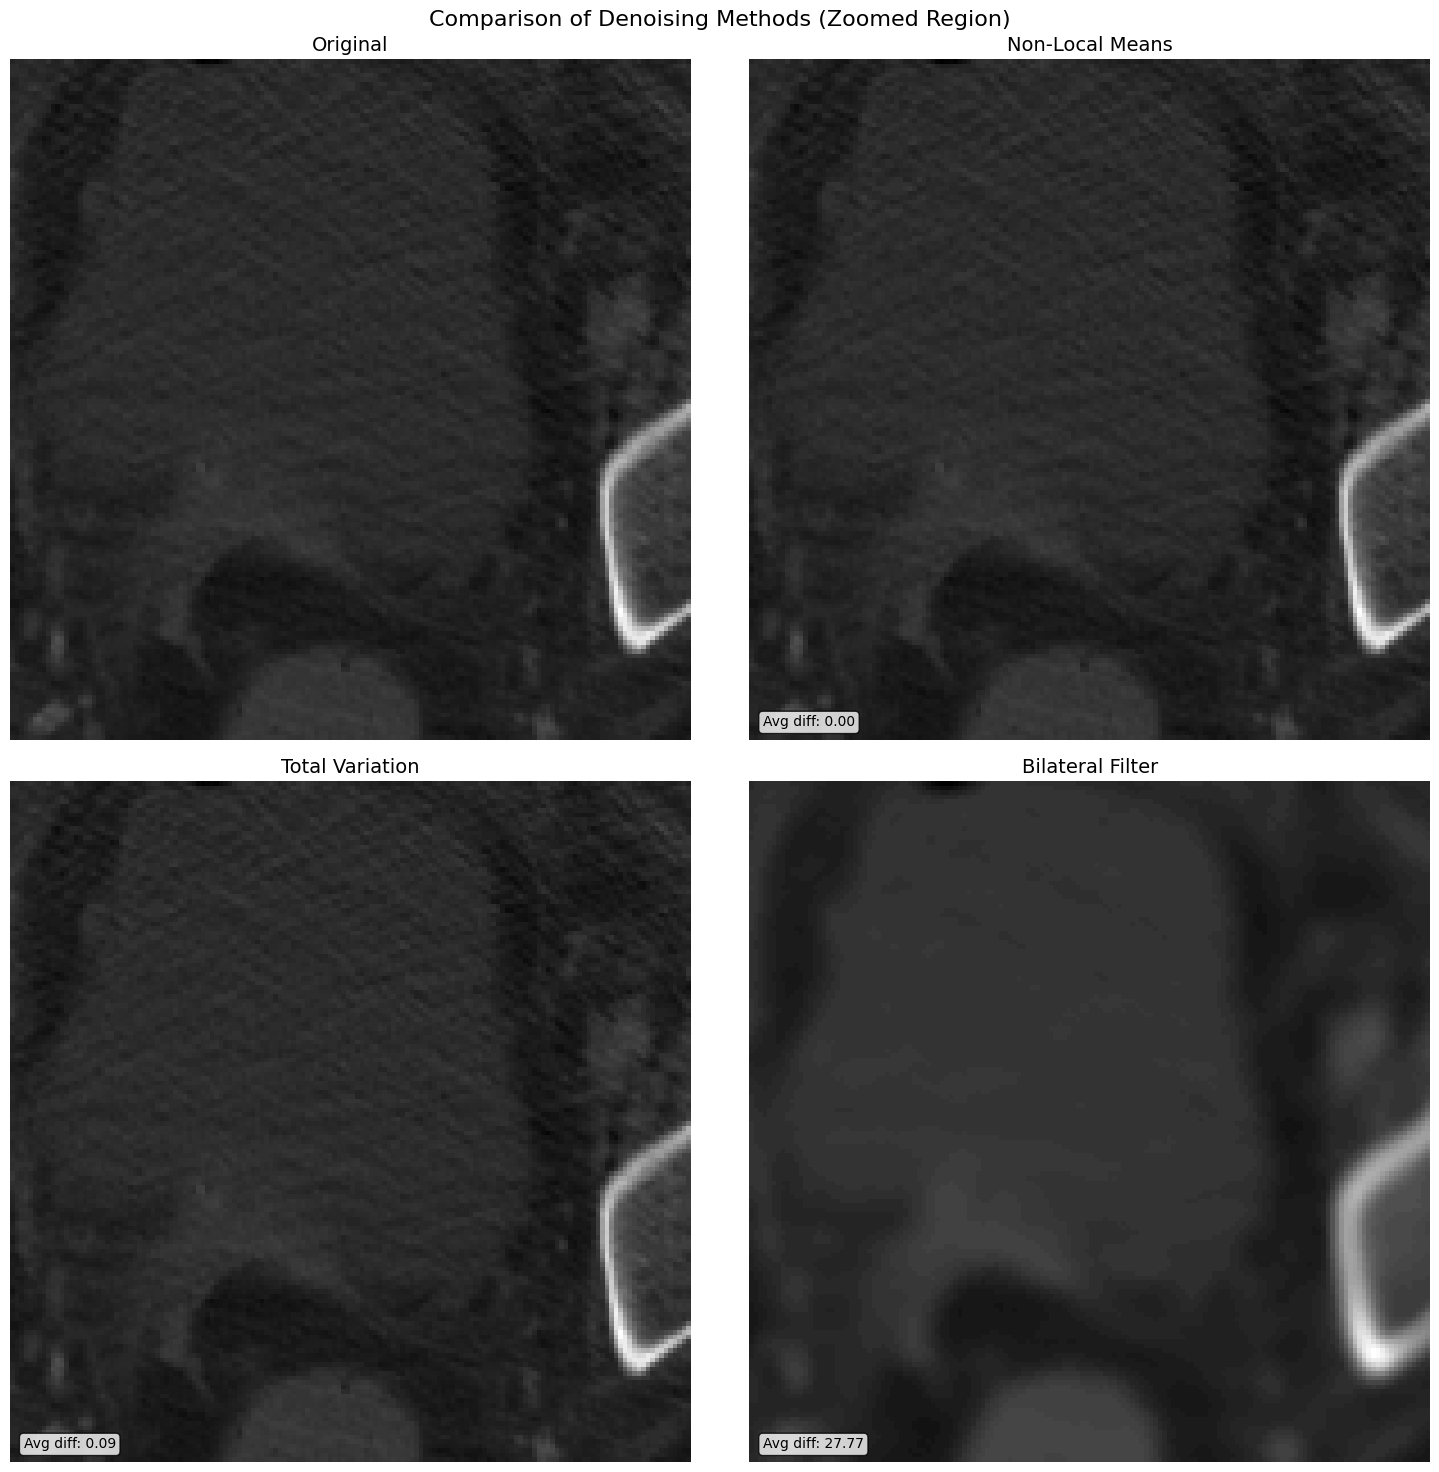

In [9]:
# Apply different denoising methods
denoising_methods = {
    "Original": ct_hu,
    "Non-Local Means": processor.denoise(ct_hu, method="nlm"),
    "Total Variation": processor.denoise(ct_hu, method="tv"),
    "Bilateral Filter": processor.denoise(ct_hu, method="bilateral")
}

# Compare denoising methods
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

slice_idx = 25
# Use a zoomed region for better comparison
zoom_slice = slice(200, 350)

for ax, (name, denoised) in zip(axes, denoising_methods.items()):
    # Show zoomed region
    ax.imshow(denoised.data[slice_idx, zoom_slice, zoom_slice], cmap='gray')
    ax.set_title(f"{name}", fontsize=14)
    ax.axis('off')
    
    # Calculate noise metrics
    if name != "Original":
        diff = np.abs(denoised.data[slice_idx] - ct_hu.data[slice_idx])
        noise_reduction = np.mean(diff)
        ax.text(0.02, 0.02, f"Avg diff: {noise_reduction:.2f}", 
                transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10)

plt.suptitle('Comparison of Denoising Methods (Zoomed Region)', fontsize=16)
plt.tight_layout()
plt.show()

### Noise Analysis

Let's analyze the effectiveness of each denoising method.

In [10]:
# Calculate signal-to-noise ratio (SNR) for each method
def calculate_snr(image_data, roi_center=(256, 256), roi_size=50):
    """Calculate SNR in a region of interest."""
    slice_idx = image_data.shape[0] // 2
    
    # Extract ROI
    y, x = roi_center
    roi = image_data[slice_idx, 
                     y-roi_size//2:y+roi_size//2, 
                     x-roi_size//2:x+roi_size//2]
    
    # Calculate SNR
    signal = np.mean(roi)
    noise = np.std(roi)
    snr = signal / noise if noise > 0 else 0
    
    return snr

# Compare SNR for different methods
print("Signal-to-Noise Ratio Comparison:")
print("-" * 40)
for name, denoised in denoising_methods.items():
    snr = calculate_snr(denoised.data)
    print(f"{name:<20}: {snr:.2f}")

Signal-to-Noise Ratio Comparison:
----------------------------------------
Original            : -9.79
Non-Local Means     : -9.79
Total Variation     : -9.80
Bilateral Filter    : -12.11


## 6. Anatomical Segmentation <a id='segmentation'></a>

Segmentation is crucial for isolating specific anatomical structures. Let's demonstrate lung segmentation.

In [11]:
# Perform lung segmentation
print("Performing lung segmentation...")
lung_mask = processor.segment_lungs(ct_hu)

# Apply mask to get segmented lungs
masked_lungs = processor.apply_mask(ct_hu, lung_mask)

print(f"Lung mask shape: {lung_mask.shape}")
print(f"Number of lung voxels: {np.sum(lung_mask):,}")
print(f"Percentage of volume: {100 * np.sum(lung_mask) / lung_mask.size:.2f}%")

Performing lung segmentation...
Lung mask shape: (101, 512, 512)
Number of lung voxels: 26,472,090
Percentage of volume: 99.98%


### Visualize Lung Segmentation

Let's visualize the segmentation results across multiple slices, focusing on the upper chest where lungs are most visible.

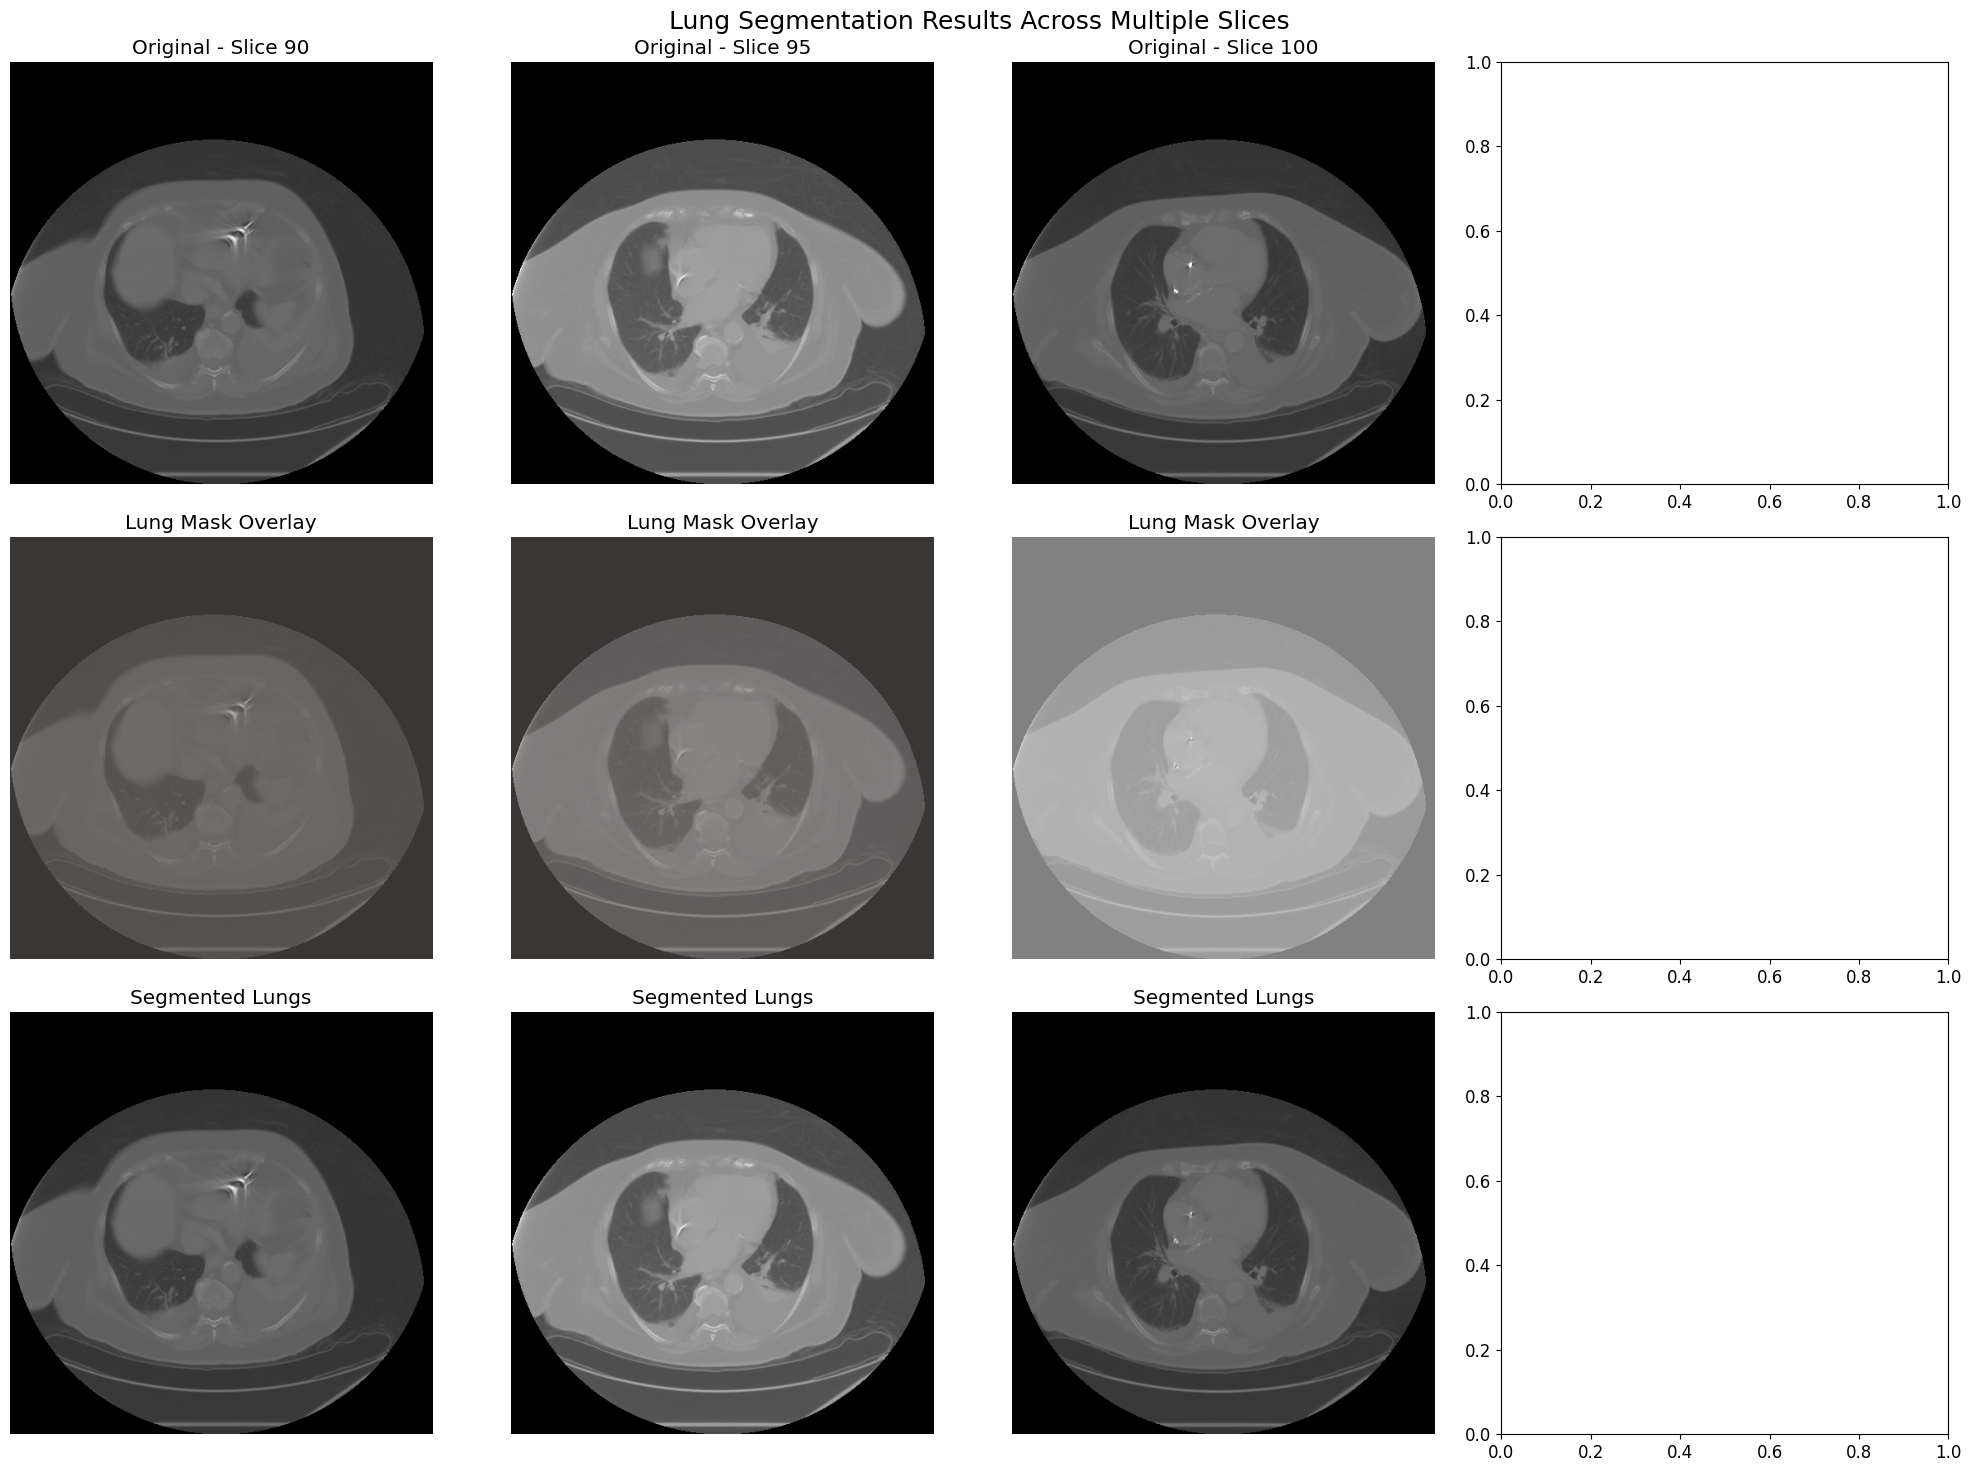

In [25]:
# Show segmentation results on multiple slices
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Use slices from upper chest area (10-40)
slice_indices = [90, 95, 100]

for col, slice_idx in enumerate(slice_indices):
    # Original CT
    axes[0, col].imshow(ct_hu.data[slice_idx], cmap='gray')
    axes[0, col].set_title(f"Original - Slice {slice_idx}")
    axes[0, col].axis('off')
    
    # Lung mask overlay
    axes[1, col].imshow(ct_hu.data[slice_idx], cmap='gray', alpha=0.7)
    axes[1, col].imshow(lung_mask[slice_idx], cmap='hot', alpha=0.3)
    axes[1, col].set_title(f"Lung Mask Overlay")
    axes[1, col].axis('off')
    
    # Segmented lungs only
    axes[2, col].imshow(masked_lungs.data[slice_idx], cmap='gray')
    axes[2, col].set_title(f"Segmented Lungs")
    axes[2, col].axis('off')

plt.suptitle('Lung Segmentation Results Across Multiple Slices', fontsize=18)
plt.tight_layout()
plt.show()

### 3D Visualization of Lung Segmentation

Let's create a 3D visualization to better understand the segmentation.

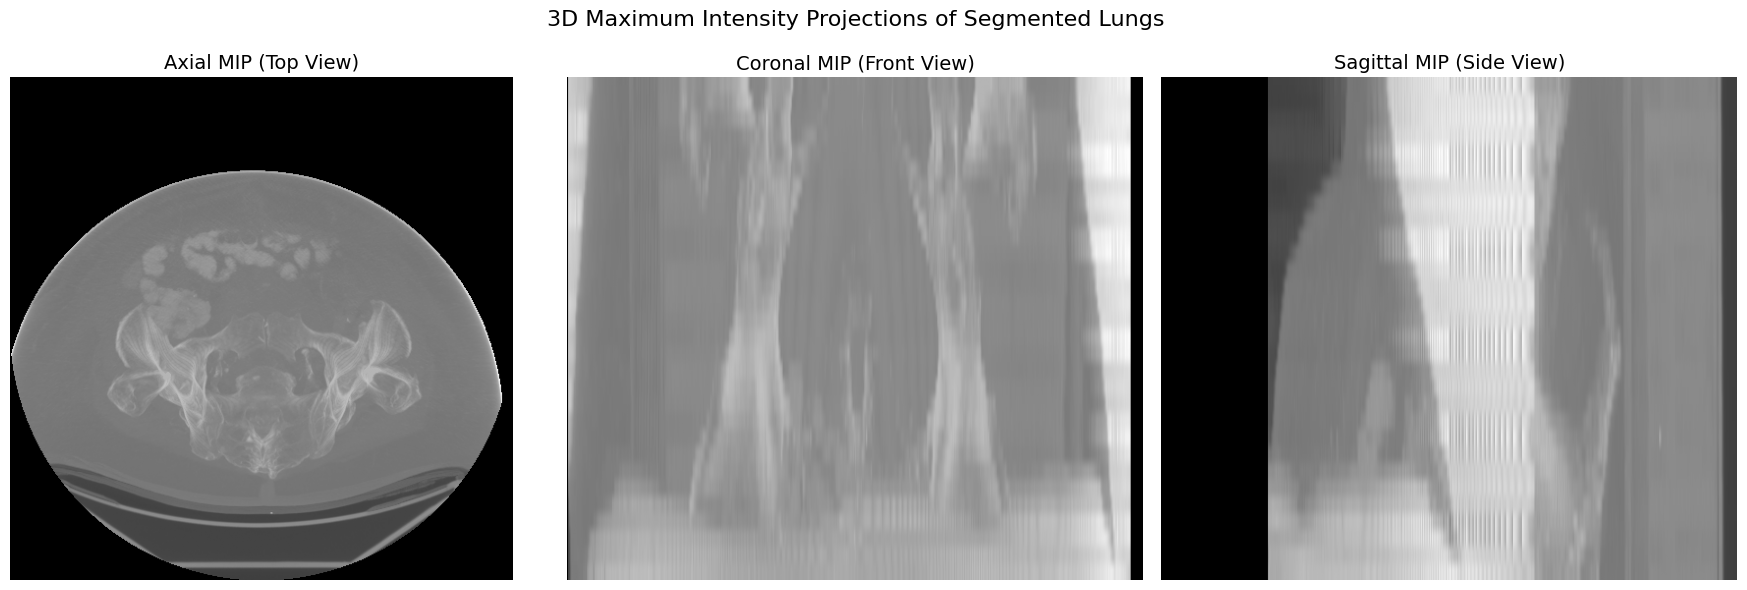

In [13]:
# Create maximum intensity projection (MIP) views
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial MIP (top-down view)
axial_mip = np.max(masked_lungs.data[10:40], axis=0)
axes[0].imshow(axial_mip, cmap='gray')
axes[0].set_title('Axial MIP (Top View)', fontsize=14)
axes[0].axis('off')

# Coronal MIP (front view)
coronal_mip = np.max(masked_lungs.data[10:40], axis=1)
axes[1].imshow(coronal_mip, cmap='gray', aspect='auto')
axes[1].set_title('Coronal MIP (Front View)', fontsize=14)
axes[1].axis('off')

# Sagittal MIP (side view)
sagittal_mip = np.max(masked_lungs.data[10:40], axis=2)
axes[2].imshow(sagittal_mip, cmap='gray', aspect='auto')
axes[2].set_title('Sagittal MIP (Side View)', fontsize=14)
axes[2].axis('off')

plt.suptitle('3D Maximum Intensity Projections of Segmented Lungs', fontsize=16)
plt.tight_layout()
plt.show()

### Segmentation Metrics

Let's calculate some quantitative metrics about the segmentation.

In [14]:
# Calculate lung volume
voxel_volume = np.prod(ct_image.metadata.get('spacing', [1, 1, 1])) / 1000  # Convert to mL
lung_volume = np.sum(lung_mask) * voxel_volume

print("Lung Segmentation Metrics:")
print("-" * 40)
print(f"Total lung volume: {lung_volume:.2f} mL")
print(f"Left lung volume: {np.sum(lung_mask[:, :, :256]) * voxel_volume:.2f} mL")
print(f"Right lung volume: {np.sum(lung_mask[:, :, 256:]) * voxel_volume:.2f} mL")

# Calculate mean HU in lungs
lung_hu_values = ct_hu.data[lung_mask]
print(f"\nMean HU in lungs: {np.mean(lung_hu_values):.2f}")
print(f"Std HU in lungs: {np.std(lung_hu_values):.2f}")

Lung Segmentation Metrics:
----------------------------------------
Total lung volume: 124990.33 mL
Left lung volume: 62496.37 mL
Right lung volume: 62493.96 mL

Mean HU in lungs: -2004.96
Std HU in lungs: 927.78


## 7. Spatial Standardization <a id='spatial'></a>

Standardizing spatial properties ensures consistency across different scans.

### Resampling to Isotropic Voxels

In [15]:
# Check current spacing
print(f"Original spacing: {ct_image.metadata.get('spacing', 'Not available')}")
print(f"Original shape: {ct_image.shape}")

# Resample to 1mm isotropic spacing
resampled = processor.resample(ct_hu, spacing=(1.0, 1.0, 1.0))

print(f"\nResampled spacing: {resampled.metadata.get('spacing')}")
print(f"Resampled shape: {resampled.shape}")
print(f"Size change: {resampled.shape[0] * resampled.shape[1] * resampled.shape[2] / (ct_image.shape[0] * ct_image.shape[1] * ct_image.shape[2]):.2f}x")

Original spacing: (0.976562, 0.976562, 4.9509500300000004)
Original shape: (101, 512, 512)

Resampled spacing: (1.0, 1.0, 1.0)
Resampled shape: (500, 500, 500)
Size change: 4.72x


### Visualize Resampling Effect

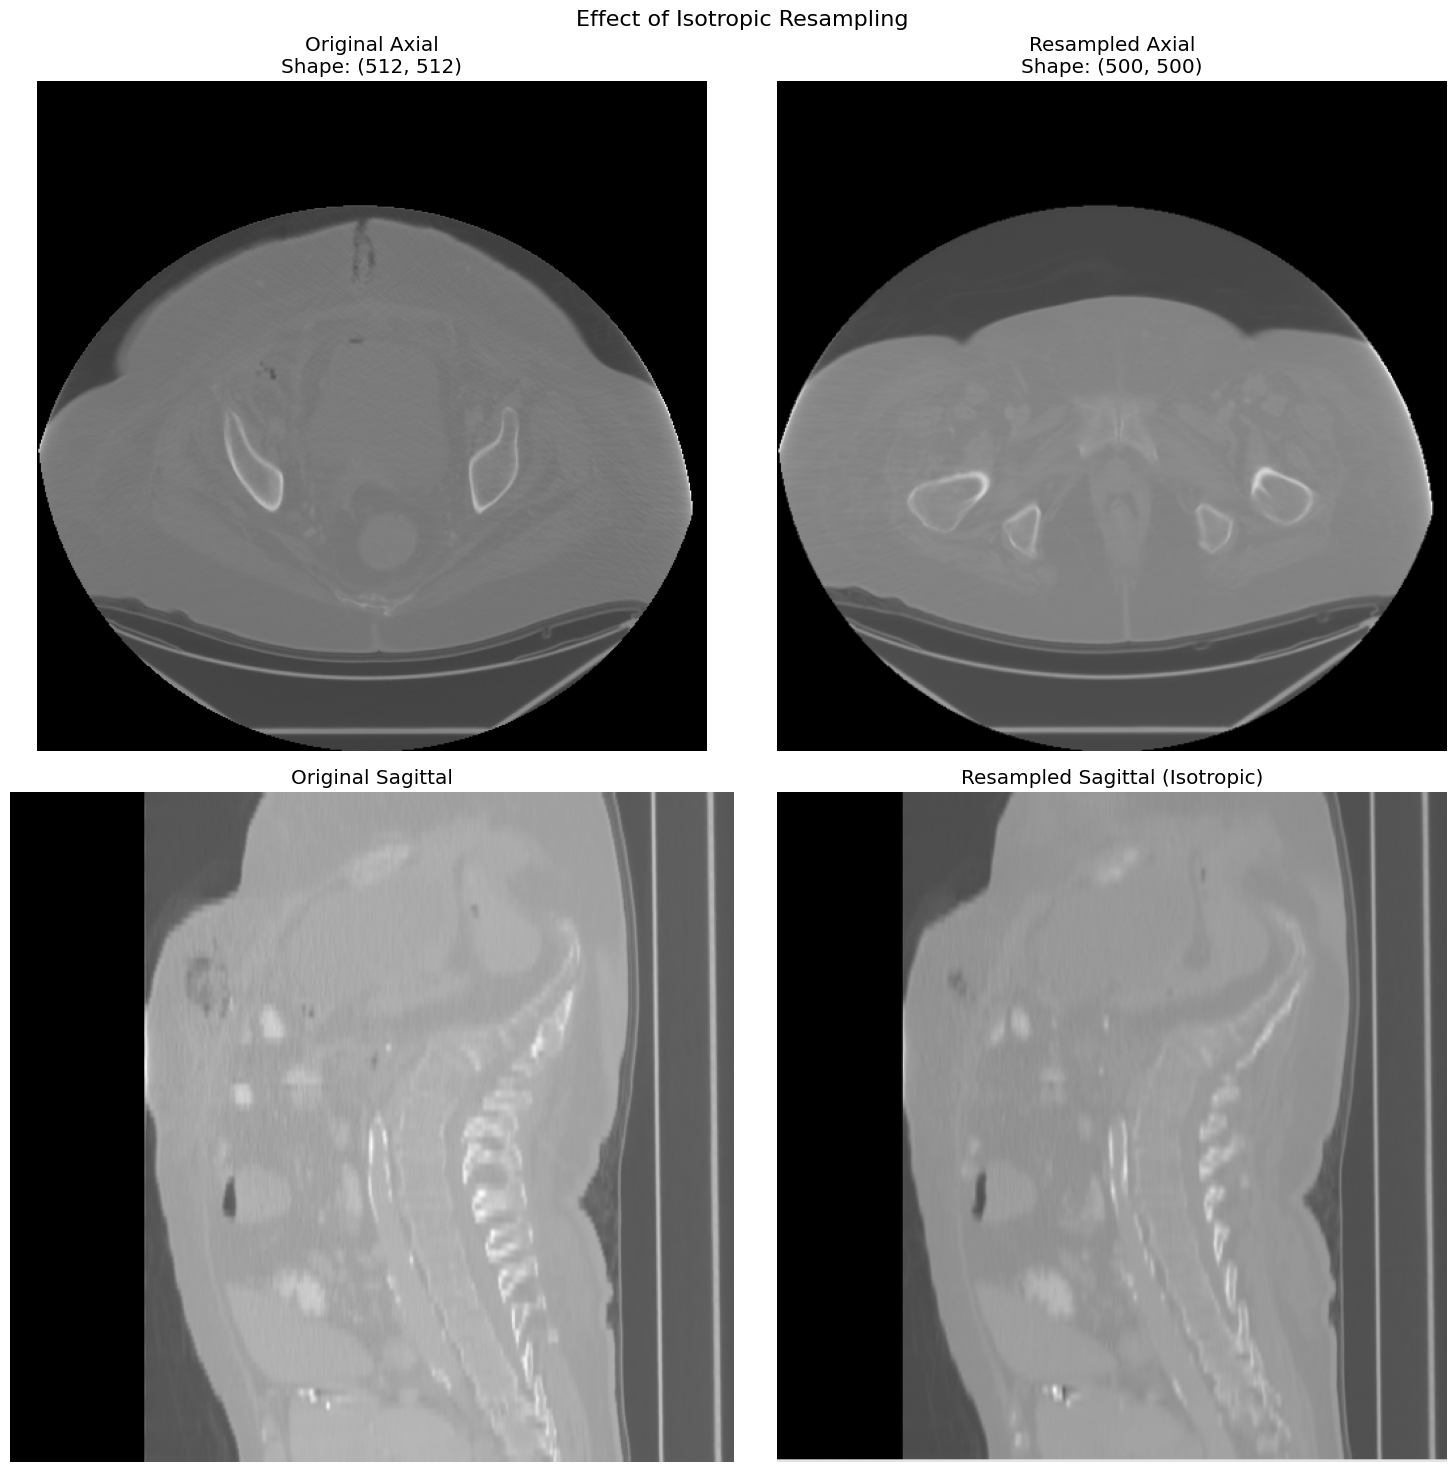

In [16]:
# Compare original and resampled
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Original axial
axes[0, 0].imshow(ct_hu.data[25], cmap='gray')
axes[0, 0].set_title(f"Original Axial\nShape: {ct_hu.data[25].shape}")
axes[0, 0].axis('off')

# Resampled axial
axes[0, 1].imshow(resampled.data[50], cmap='gray')
axes[0, 1].set_title(f"Resampled Axial\nShape: {resampled.data[50].shape}")
axes[0, 1].axis('off')

# Original sagittal
axes[1, 0].imshow(ct_hu.data[:, :, 256], cmap='gray', aspect='auto')
axes[1, 0].set_title("Original Sagittal")
axes[1, 0].axis('off')

# Resampled sagittal
axes[1, 1].imshow(resampled.data[:, :, 256], cmap='gray')
axes[1, 1].set_title("Resampled Sagittal (Isotropic)")
axes[1, 1].axis('off')

plt.suptitle('Effect of Isotropic Resampling', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Intensity Normalization <a id='normalization'></a>

Different normalization methods are suitable for different analysis tasks.

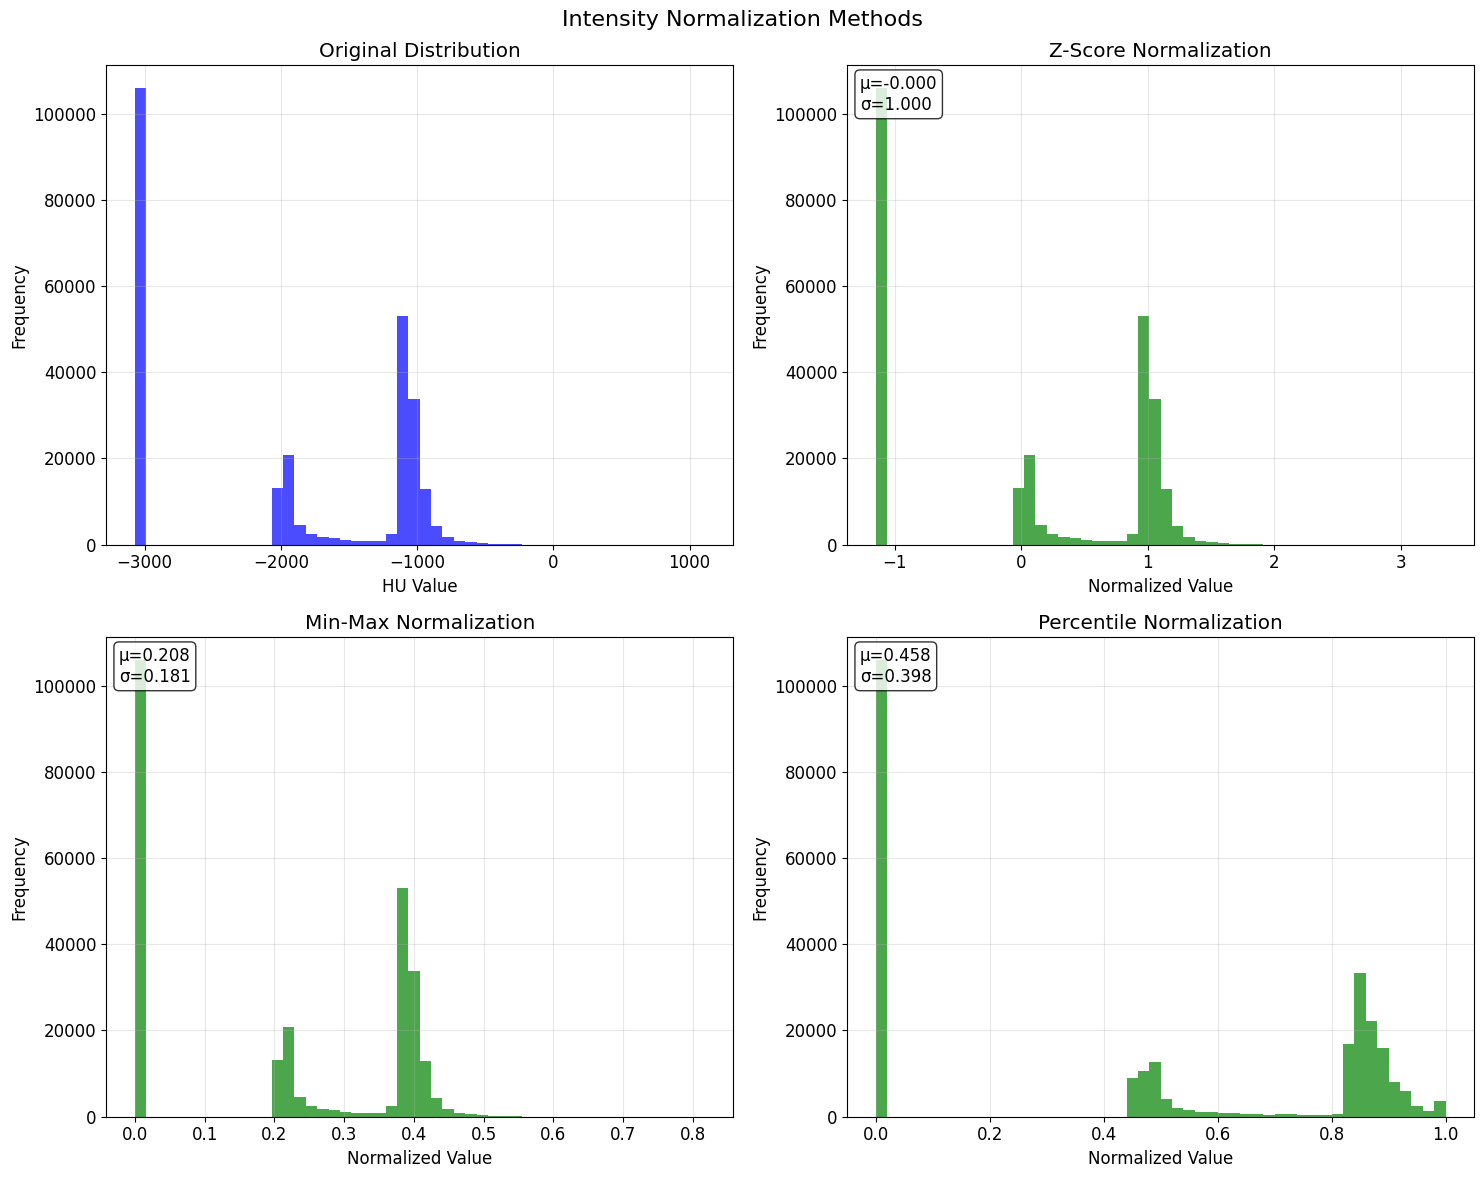

In [17]:
# Apply different normalization methods
norm_methods = {
    "Z-Score": processor.normalize_intensity(ct_hu, method="z_score"),
    "Min-Max": processor.normalize_intensity(ct_hu, method="min_max"),
    "Percentile": processor.normalize_intensity(ct_hu, method="percentile")
}

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Original histogram
axes[0].hist(ct_hu.data.flatten()[::100], bins=50, alpha=0.7, color='blue')
axes[0].set_title("Original Distribution")
axes[0].set_xlabel("HU Value")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, alpha=0.3)

# Normalized histograms
for idx, (name, normalized) in enumerate(norm_methods.items(), 1):
    axes[idx].hist(normalized.data.flatten()[::100], bins=50, alpha=0.7, color='green')
    axes[idx].set_title(f"{name} Normalization")
    axes[idx].set_xlabel("Normalized Value")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(normalized.data)
    std_val = np.std(normalized.data)
    axes[idx].text(0.02, 0.98, f"μ={mean_val:.3f}\nσ={std_val:.3f}", 
                   transform=axes[idx].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

plt.suptitle('Intensity Normalization Methods', fontsize=16)
plt.tight_layout()
plt.show()

## 9. Embedding Generation <a id='embeddings'></a>

Generate embeddings for downstream AI tasks like classification or retrieval.

In [18]:
# Preprocess image for embedding generation
preprocessed = processor.preprocess(
    ct_image,
    denoise=True,
    correct_artifacts=True,
    resample_spacing=(2.0, 2.0, 2.0),  # Downsample for efficiency
    normalize=True
)

print(f"Preprocessed shape: {preprocessed.shape}")

2025-06-20 09:59:08,928 - honeybee.processors.radiology_processor - WARNING - Unusual HU range: [-3072.0, 2048.0]


Preprocessed shape: (250, 250, 250)


### 2D vs 3D Embeddings

In [19]:
# Generate 2D embedding (from middle slice)
embedding_2d = processor.generate_embeddings(preprocessed, mode="2d")
print(f"2D embedding shape: {embedding_2d.shape}")

# Generate 3D embeddings (per-slice embeddings)
# Note: This will generate placeholder embeddings since REMEDIS needs proper model weights
print("\nGenerating 3D embeddings (this may take a moment)...")
embeddings_3d = processor.generate_embeddings(preprocessed, mode="3d")
print(f"3D embeddings shape: {embeddings_3d.shape}")

# Aggregate embeddings
agg_mean = processor.aggregate_embeddings(embeddings_3d, method="mean")
agg_max = processor.aggregate_embeddings(embeddings_3d, method="max")
agg_weighted = processor.aggregate_embeddings(embeddings_3d, method="weighted")

print(f"\nAggregated embedding shapes:")
print(f"  Mean aggregation: {agg_mean.shape}")
print(f"  Max aggregation: {agg_max.shape}")
print(f"  Weighted aggregation: {agg_weighted.shape}")

2025-06-20 09:59:26,344 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,345 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,346 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,348 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,349 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,350 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model p

2D embedding shape: (1, 768)

Generating 3D embeddings (this may take a moment)...


2025-06-20 09:59:26,355 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,356 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,357 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,358 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,360 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.
2025-06-20 09:59:26,361 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model p

3D embeddings shape: (250, 768)

Aggregated embedding shapes:
  Mean aggregation: (768,)
  Max aggregation: (768,)
  Weighted aggregation: (768,)


### Visualize Embedding Space

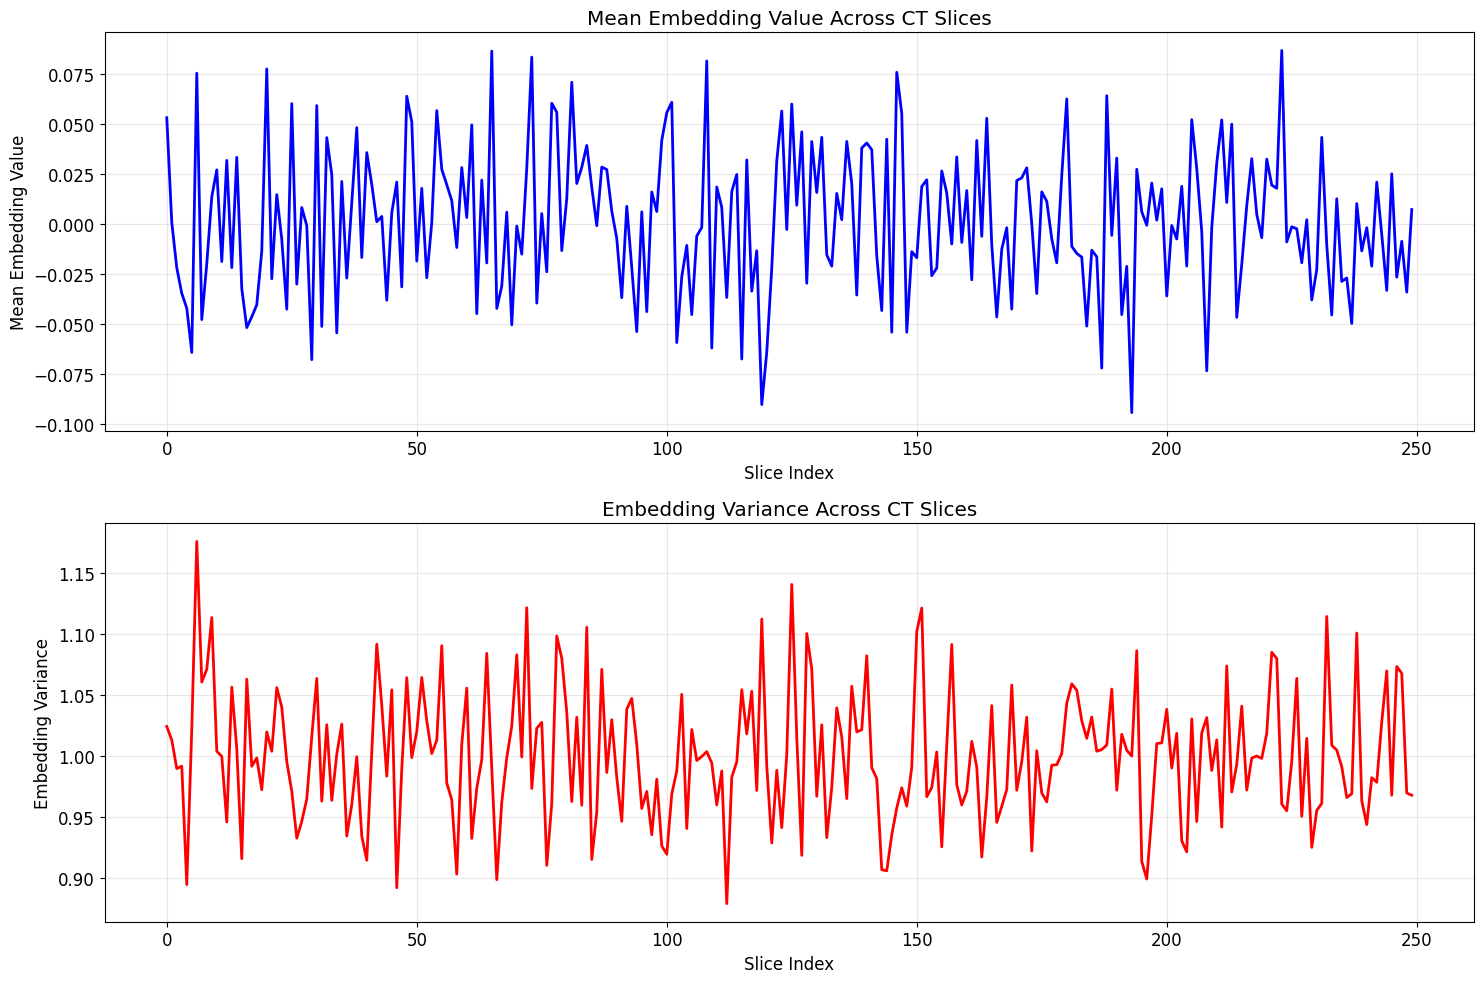

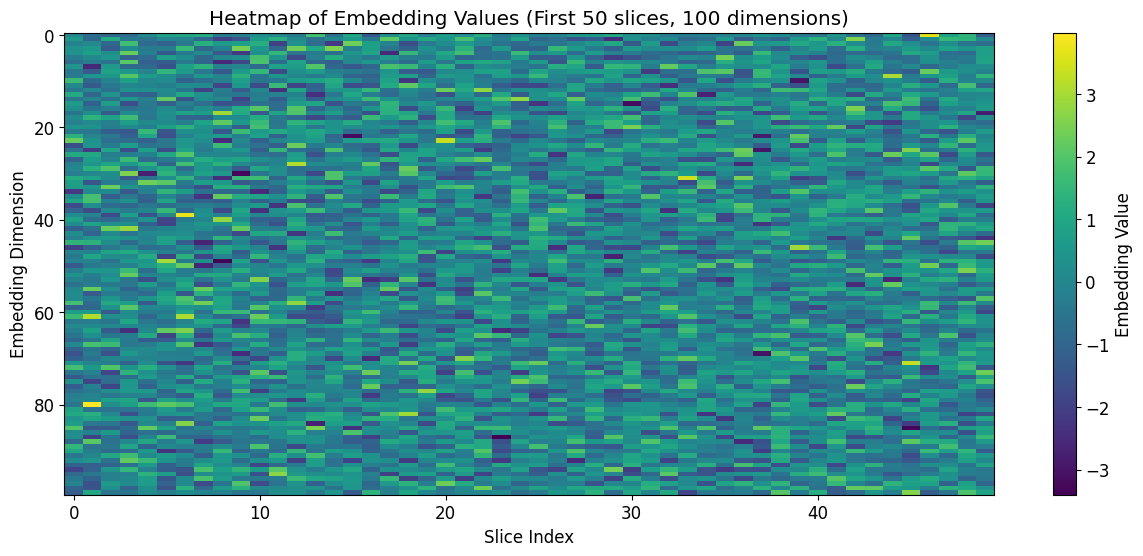

In [20]:
# Visualize embedding values across slices
if len(embeddings_3d.shape) == 2 and embeddings_3d.shape[0] > 1:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Mean embedding value per slice
    mean_per_slice = np.mean(embeddings_3d, axis=1)
    axes[0].plot(mean_per_slice, 'b-', linewidth=2)
    axes[0].set_xlabel('Slice Index')
    axes[0].set_ylabel('Mean Embedding Value')
    axes[0].set_title('Mean Embedding Value Across CT Slices')
    axes[0].grid(True, alpha=0.3)
    
    # Embedding variance per slice
    var_per_slice = np.var(embeddings_3d, axis=1)
    axes[1].plot(var_per_slice, 'r-', linewidth=2)
    axes[1].set_xlabel('Slice Index')
    axes[1].set_ylabel('Embedding Variance')
    axes[1].set_title('Embedding Variance Across CT Slices')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize embedding dimensions
plt.figure(figsize=(15, 6))
plt.imshow(embeddings_3d[:50, :100].T, aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.xlabel('Slice Index')
plt.ylabel('Embedding Dimension')
plt.title('Heatmap of Embedding Values (First 50 slices, 100 dimensions)')
plt.show()

## 10. Complete Pipeline Example <a id='pipeline'></a>

Let's put it all together in a complete processing pipeline.

2025-06-20 09:59:26,947 - honeybee.processors.radiology_processor - INFO - RadiologyProcessor initialized with remedis model on cuda


CT SCAN PROCESSING PIPELINE

1. Loading DICOM series...


ImageSeriesReader (0x221aea80): Non uniform sampling or missing slices detected,  maximum nonuniformity:4.85595

2025-06-20 09:59:29,559 - honeybee.processors.radiology_processor - WARNING - Unusual HU range: [-3072.0, 2048.0]


   ✓ Loaded: (101, 512, 512)

2. Verifying Hounsfield units...
   ✓ HU range: [-3072.0, 2048.0]

3. Applying denoising...
   ✓ Non-local means denoising applied

4. Segmenting lungs...
   ✓ Lung volume: 124990.33 mL

5. Normalizing intensities...
   ✓ Percentile normalization applied

6. Resampling to isotropic spacing...


2025-06-20 09:59:47,316 - honeybee.processors.radiology_processor - WARNING - remedis model requires proper initialization with model path. Returning placeholder embedding.


   ✓ Resampled to: (333, 333, 333)

7. Generating embeddings...
   ✓ Embedding shape: (1, 768)

8. Creating summary visualization...


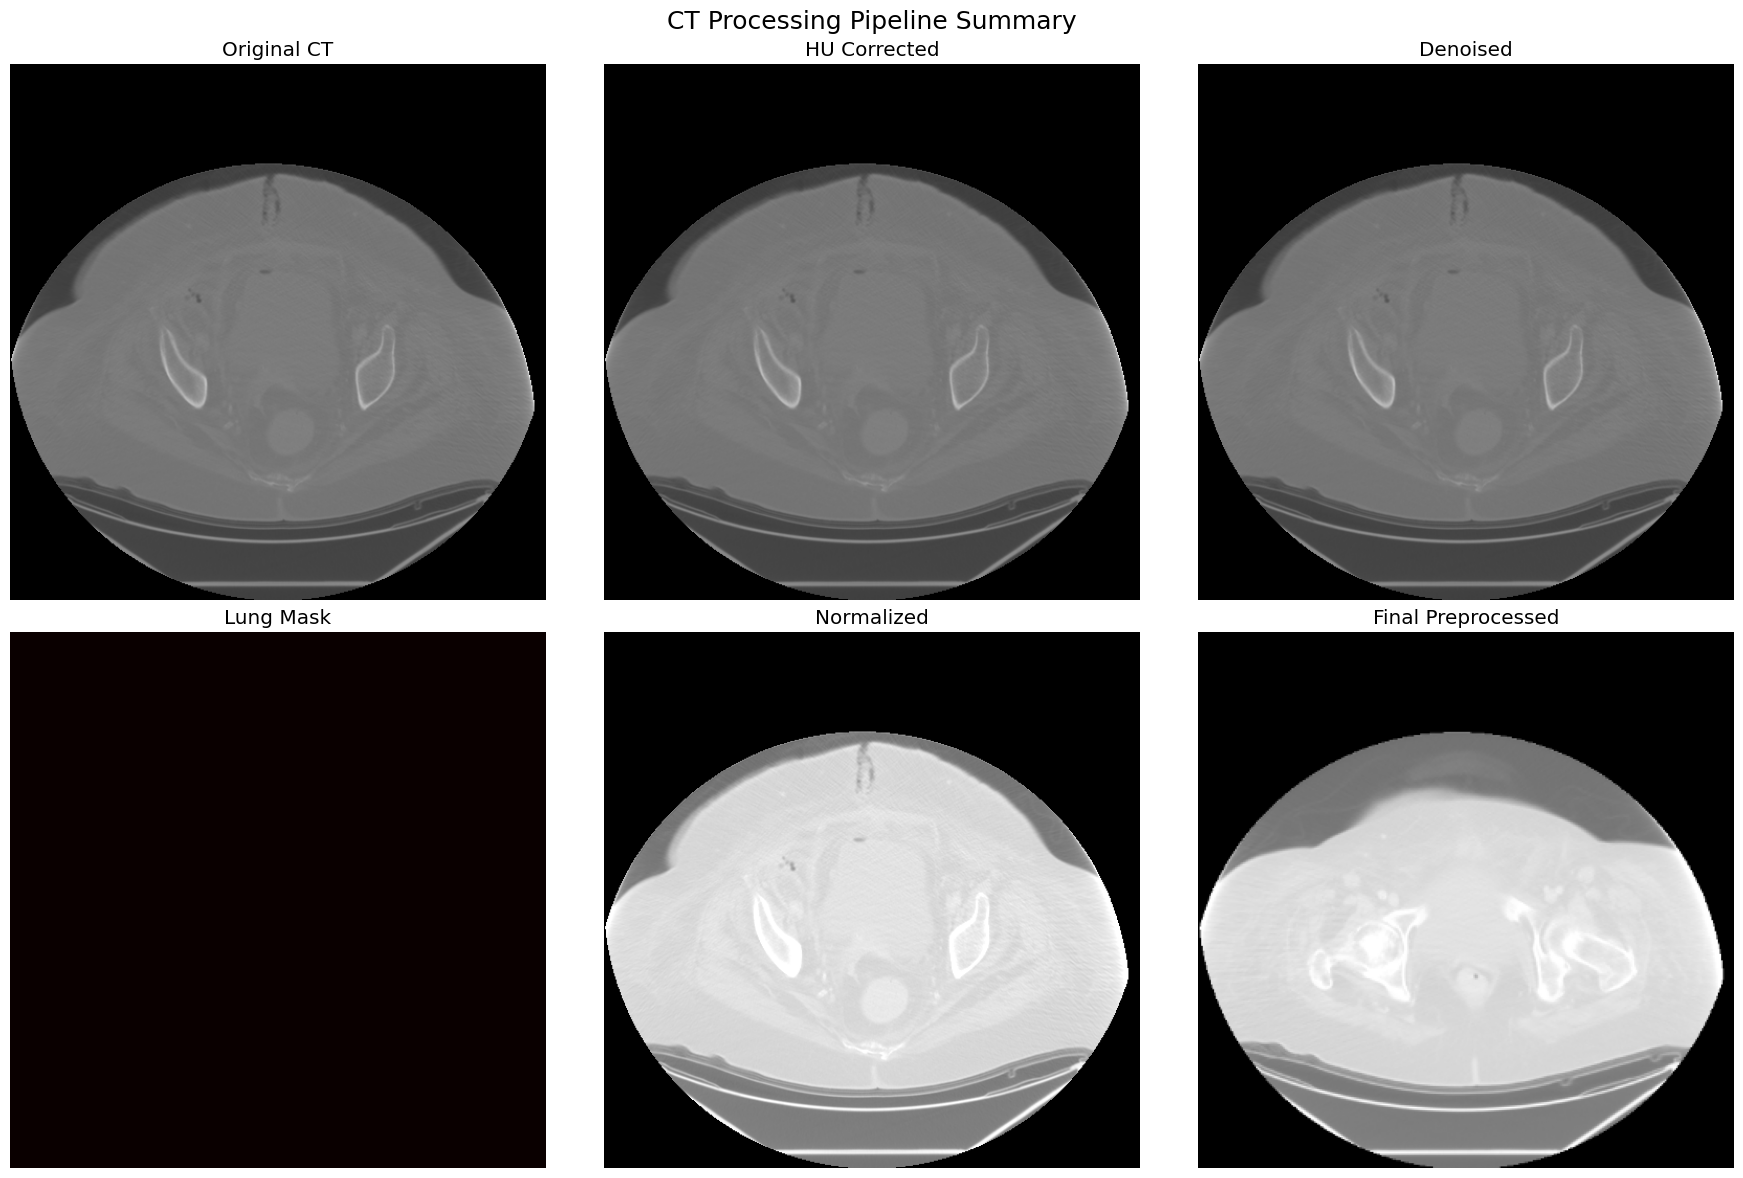


PROCESSING COMPLETE
Results saved to: /mnt/f/Projects/HoneyBee/processed_results


In [21]:
def process_ct_scan(ct_path, output_dir="./processed_results/"):
    """
    Complete processing pipeline for CT scan.
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Initialize processor
    processor = RadiologyProcessor(model="remedis")
    
    print("=" * 50)
    print("CT SCAN PROCESSING PIPELINE")
    print("=" * 50)
    
    # Step 1: Load DICOM
    print("\n1. Loading DICOM series...")
    ct_image = processor.load_dicom(ct_path)
    print(f"   ✓ Loaded: {ct_image.shape}")
    
    # Step 2: Verify HU
    print("\n2. Verifying Hounsfield units...")
    ct_hu = processor.verify_hounsfield_units(ct_image)
    print(f"   ✓ HU range: [{ct_hu.data.min():.1f}, {ct_hu.data.max():.1f}]")
    
    # Step 3: Denoise
    print("\n3. Applying denoising...")
    denoised = processor.denoise(ct_hu, method="nlm")
    print("   ✓ Non-local means denoising applied")
    
    # Step 4: Segment lungs
    print("\n4. Segmenting lungs...")
    try:
        lung_mask = processor.segment_lungs(denoised)
        lung_volume = np.sum(lung_mask) * np.prod(ct_image.metadata.get('spacing', [1, 1, 1])) / 1000
        print(f"   ✓ Lung volume: {lung_volume:.2f} mL")
        
        # Save lung mask
        np.save(output_path / "lung_mask.npy", lung_mask)
    except Exception as e:
        print(f"   ⚠ Lung segmentation failed: {e}")
        lung_mask = None
    
    # Step 5: Normalize
    print("\n5. Normalizing intensities...")
    normalized = processor.normalize_intensity(denoised, method="percentile")
    print("   ✓ Percentile normalization applied")
    
    # Step 6: Resample
    print("\n6. Resampling to isotropic spacing...")
    resampled = processor.resample(normalized, spacing=(1.5, 1.5, 1.5))
    print(f"   ✓ Resampled to: {resampled.shape}")
    
    # Step 7: Generate embeddings
    print("\n7. Generating embeddings...")
    embeddings = processor.generate_embeddings(resampled, mode="2d")
    print(f"   ✓ Embedding shape: {embeddings.shape}")
    
    # Save embeddings
    np.save(output_path / "embeddings.npy", embeddings)
    
    # Create summary visualization
    print("\n8. Creating summary visualization...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    slice_idx = min(25, ct_image.shape[0] // 2)
    
    # Original
    axes[0].imshow(ct_image.data[slice_idx], cmap='gray')
    axes[0].set_title("Original CT")
    axes[0].axis('off')
    
    # HU corrected
    axes[1].imshow(ct_hu.data[slice_idx], cmap='gray')
    axes[1].set_title("HU Corrected")
    axes[1].axis('off')
    
    # Denoised
    axes[2].imshow(denoised.data[slice_idx], cmap='gray')
    axes[2].set_title("Denoised")
    axes[2].axis('off')
    
    # Lung mask
    if lung_mask is not None:
        axes[3].imshow(lung_mask[slice_idx], cmap='hot')
        axes[3].set_title("Lung Mask")
    else:
        axes[3].text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=20)
        axes[3].set_title("Lung Mask (Failed)")
    axes[3].axis('off')
    
    # Normalized
    axes[4].imshow(normalized.data[slice_idx], cmap='gray')
    axes[4].set_title("Normalized")
    axes[4].axis('off')
    
    # Final preprocessed
    final_slice_idx = min(slice_idx * 2, resampled.shape[0] - 1)
    axes[5].imshow(resampled.data[final_slice_idx], cmap='gray')
    axes[5].set_title("Final Preprocessed")
    axes[5].axis('off')
    
    plt.suptitle('CT Processing Pipeline Summary', fontsize=18)
    plt.tight_layout()
    plt.savefig(output_path / "pipeline_summary.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "=" * 50)
    print("PROCESSING COMPLETE")
    print(f"Results saved to: {output_path.absolute()}")
    print("=" * 50)
    
    return {
        'embeddings': embeddings,
        'lung_mask': lung_mask,
        'processed_image': resampled
    }

# Run the complete pipeline
results = process_ct_scan(ct_dir)

## 11. Advanced Topics <a id='advanced'></a>

### Metal Artifact Reduction

For CT scans with metal implants:

In [22]:
# Detect and reduce metal artifacts
# Check if there are high HU values indicating metal
metal_threshold = 3000
has_metal = np.any(ct_hu.data > metal_threshold)

if has_metal:
    print("Metal artifacts detected! Applying reduction...")
    reduced = processor.reduce_metal_artifacts(ct_hu)
    
    # Visualize the effect
    slice_with_metal = np.argmax(np.max(ct_hu.data, axis=(1, 2)) > metal_threshold)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(ct_hu.data[slice_with_metal], cmap='gray')
    axes[0].set_title("Original with Metal Artifacts")
    axes[0].axis('off')
    
    axes[1].imshow(reduced.data[slice_with_metal], cmap='gray')
    axes[1].set_title("After Metal Artifact Reduction")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No significant metal artifacts detected in this scan.")

No significant metal artifacts detected in this scan.


### Multi-Modality Processing

HoneyBee can handle different imaging modalities with appropriate preprocessing:

In [23]:
# Example: Processing parameters for different modalities
modality_configs = {
    "CT": {
        "denoise_method": "nlm",
        "normalize_method": "percentile",
        "window_presets": ["lung", "soft_tissue", "bone"]
    },
    "MRI": {
        "denoise_method": "rician",  # MRI-specific noise model
        "normalize_method": "z_score",
        "bias_correction": True
    },
    "PET": {
        "denoise_method": "pet_specific",
        "normalize_method": "min_max",
        "calculate_suv": True
    }
}

# Display modality-specific processing
for modality, config in modality_configs.items():
    print(f"\n{modality} Processing Configuration:")
    print("-" * 40)
    for key, value in config.items():
        print(f"  {key}: {value}")


CT Processing Configuration:
----------------------------------------
  denoise_method: nlm
  normalize_method: percentile
  window_presets: ['lung', 'soft_tissue', 'bone']

MRI Processing Configuration:
----------------------------------------
  denoise_method: rician
  normalize_method: z_score
  bias_correction: True

PET Processing Configuration:
----------------------------------------
  denoise_method: pet_specific
  normalize_method: min_max
  calculate_suv: True


### Performance Optimization Tips

When processing large datasets:

In [24]:
# Memory-efficient processing example
def process_large_dataset(dicom_paths, batch_size=10):
    """
    Process multiple CT scans efficiently.
    """
    processor = RadiologyProcessor(model="remedis")
    all_embeddings = []
    
    for i in range(0, len(dicom_paths), batch_size):
        batch_paths = dicom_paths[i:i+batch_size]
        
        for path in batch_paths:
            # Process with lower resolution for speed
            ct = processor.load_dicom(path)
            
            # Quick preprocessing
            preprocessed = processor.preprocess(
                ct,
                denoise=False,  # Skip for speed
                resample_spacing=(3.0, 3.0, 3.0),  # Lower resolution
                normalize=True
            )
            
            # Generate embeddings
            embedding = processor.generate_embeddings(preprocessed, mode="2d")
            all_embeddings.append(embedding)
            
            # Clear memory
            del ct, preprocessed
            
        print(f"Processed batch {i//batch_size + 1}")
    
    return np.vstack(all_embeddings)

print("Example batch processing function defined.")
print("\nOptimization tips:")
print("- Use lower resolution for initial screening")
print("- Process in batches to manage memory")
print("- Skip non-essential preprocessing steps")
print("- Use GPU acceleration when available")
print("- Cache intermediate results")

Example batch processing function defined.

Optimization tips:
- Use lower resolution for initial screening
- Process in batches to manage memory
- Skip non-essential preprocessing steps
- Use GPU acceleration when available
- Cache intermediate results


## Summary

In this tutorial, we've covered:

1. **Loading medical images** from DICOM format
2. **Preprocessing techniques** including HU correction and denoising
3. **Window/level adjustment** for optimal visualization
4. **Anatomical segmentation** with focus on lung extraction
5. **Spatial standardization** through resampling
6. **Intensity normalization** methods
7. **Embedding generation** for AI applications
8. **Complete processing pipeline** implementation

### Next Steps

- Experiment with different preprocessing parameters
- Try processing different types of medical images (MRI, PET)
- Integrate the embeddings with downstream ML models
- Explore multi-modal fusion with HoneyBee's integration capabilities

### Resources

- [HoneyBee Documentation](https://github.com/VectorInstitute/HoneyBee)
- [Medical Image Processing Best Practices](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3372692/)
- [DICOM Standard](https://www.dicomstandard.org/)